<a href="https://colab.research.google.com/github/mohitraosatya/neuromorphic_Audio_Analysis./blob/main/encode_spikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install required packages
!pip install -q torchaudio spikingjelly matplotlib librosa ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.6/437.6 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.0 MB/s eta 0:00:00


100%|██████████| 427k/427k [00:00<00:00, 7.47MB/s]


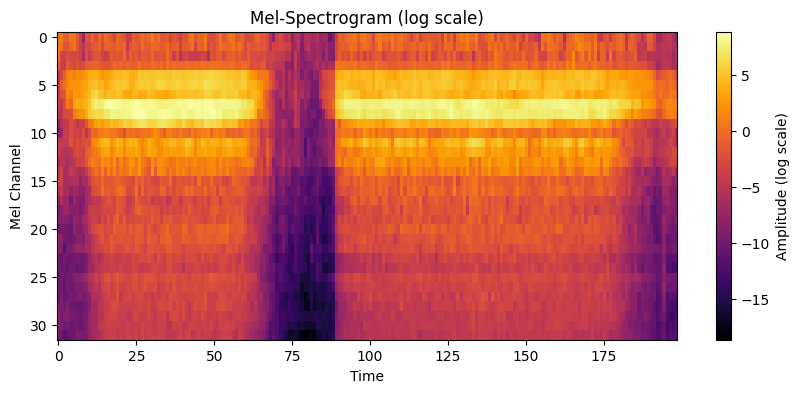

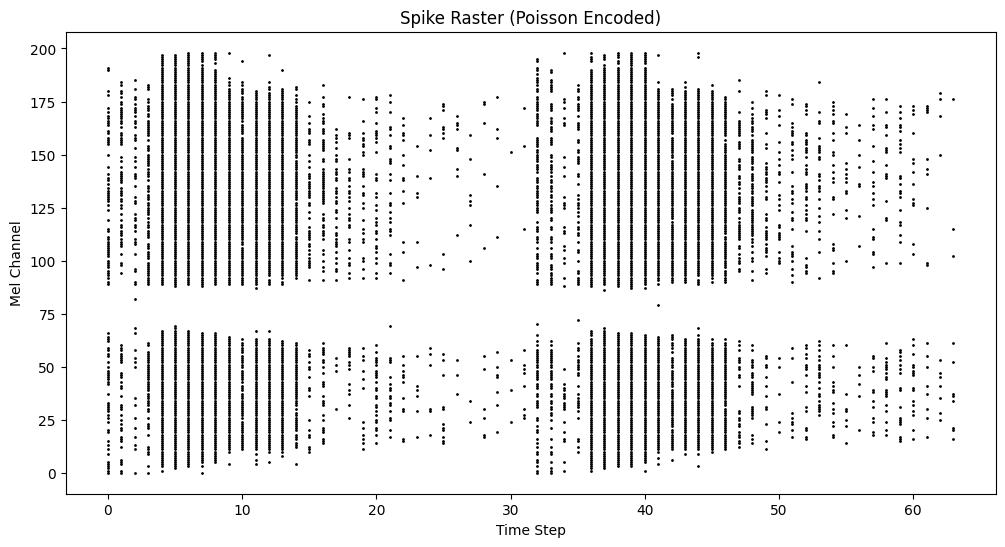

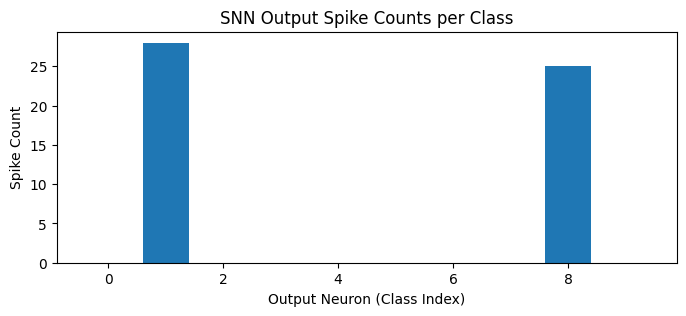

In [3]:
# Import necessary libraries
import torchaudio
import torch
import librosa
import matplotlib.pyplot as plt
import numpy as np
from spikingjelly.activation_based import encoding, neuron, functional, surrogate, layer
from torchaudio.transforms import MelSpectrogram
import IPython.display as ipd
import os

# Set up parameters
sample_rate = 16000
n_mels = 32
frame_length = 64

# Load and preprocess a sample audio file from torchaudio
waveform, sr = torchaudio.load(torchaudio.utils.download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav"))
waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)(waveform)

# Play audio
ipd.display(ipd.Audio(waveform.numpy(), rate=sample_rate))

# Convert to Mel Spectrogram
mel_spec = MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels)(waveform).squeeze(0)
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec.log2()[0, :, :].detach().numpy(), cmap='inferno', aspect='auto')
plt.title("Mel-Spectrogram (log scale)")
plt.xlabel("Time")
plt.ylabel("Mel Channel")
plt.colorbar(label='Amplitude (log scale)')
plt.show()

# Convert Mel Spectrogram to spike trains (Poisson encoding)
spike_encoder = encoding.PoissonEncoder()
encoded_spikes = spike_encoder(mel_spec.unsqueeze(0))

# Plot raster of spike activity
def plot_raster(spike_tensor):
    spike_data = spike_tensor.squeeze(0).detach().numpy()

    # Ensure it's (T, C) shaped
    if spike_data.ndim == 3:
        # Reshape spike_data to have 2 dimensions (time steps, channels)
        spike_data = spike_data.reshape(spike_data.shape[0] * spike_data.shape[1], spike_data.shape[2])
        #spike_data = spike_data.squeeze()

    time_steps, channels = spike_data.shape
    plt.figure(figsize=(12, 6))
    for ch in range(channels):
        ts = np.where(spike_data[:, ch] > 0)[0]
        plt.scatter(ts, [ch] * len(ts), s=1, color='black')

    plt.title("Spike Raster (Poisson Encoded)")
    plt.xlabel("Time Step")
    plt.ylabel("Mel Channel")
    plt.show()


plot_raster(encoded_spikes)

# Simulate a basic 1-layer SNN for demo (not trained)
class SimpleSNN(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc = layer.Linear(in_features, out_features)
        self.neuron = neuron.LIFNode(surrogate_function=surrogate.Sigmoid())

    def forward(self, x_seq):
        self.neuron.reset()
        outputs = []
        for t in range(x_seq.size(0)):
            out = self.fc(x_seq[t])
            out = self.neuron(out)
            outputs.append(out)
        return torch.stack(outputs)

# Flatten spikes and run through the SNN
snn = SimpleSNN(in_features=n_mels, out_features=10)  # Assuming 10 classes
flattened_input = encoded_spikes.squeeze().reshape(-1, encoded_spikes.shape[-2]) # Reshape to [T, C]
outputs = snn(flattened_input)
output_spikes = outputs.sum(0).detach().numpy()

# Plot output activity
plt.figure(figsize=(8, 3))
plt.bar(range(len(output_spikes)), output_spikes)
plt.title("SNN Output Spike Counts per Class")
plt.xlabel("Output Neuron (Class Index)")
plt.ylabel("Spike Count")
plt.show()
